In [61]:
# Cálculo de relaciones lluvia escurrimiento.

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import geopandas as gpd

from scipy import integrate

In [62]:
# Dirección de los datos.
path = "../Material/Clases/Clase 17/"

# Escurrimiento.
esc_n  = "Escurrimiento.csv"
# Curva masa.
inf_n   = "infiltracion.csv"

# Cargamos los datos.
esc = pd.read_csv(path + esc_n, index_col = "tiempo")
esc.index = pd.to_datetime(esc.index)
inf  = pd.read_csv(path + inf_n, index_col = "tiempo")
inf.index = pd.to_datetime(inf.index)
inf.index.name = esc.index.name

In [63]:
# Hidrograma unitario tradicional.

# Calculamos la duración en exceso y precipitación en exceso.
d_e = ( inf["he [mm]"] > 0 ).sum()
h_e = inf["he [mm]"].sum()

# Calculamos el hidrograma unitario tradicional.
esc["q"] = ( esc["Q_D"] / h_e )

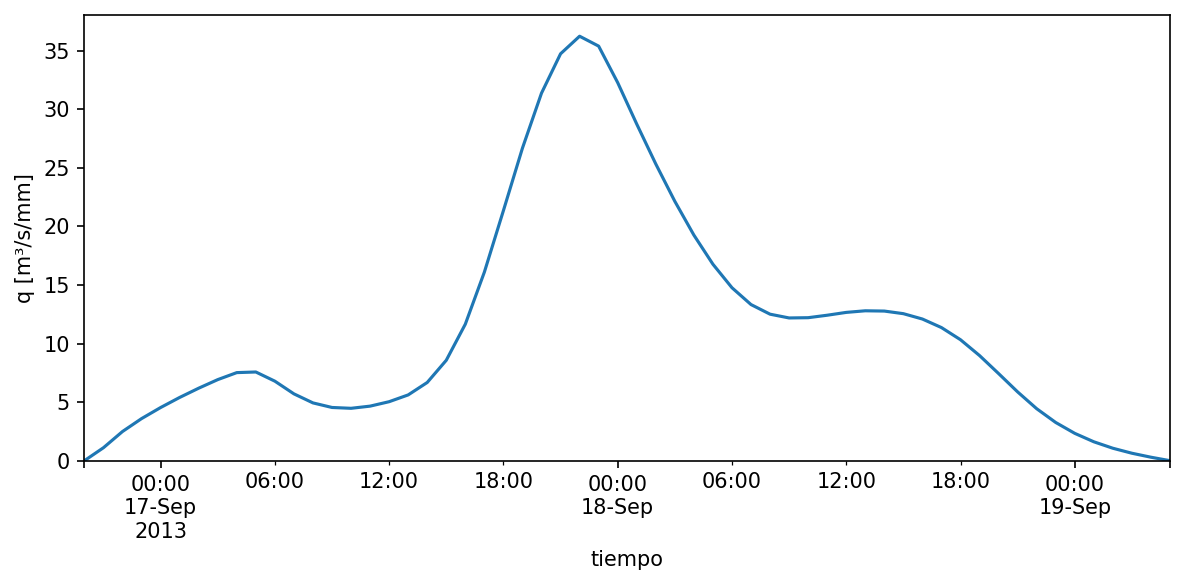

In [64]:
# Hidrograma unitario tradicional.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Graficamos.
esc["q"].plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_xlim( esc.index.min(), esc.index.max() )
ax.set_ylabel("q [m³/s/mm]")

fig.tight_layout()
plt.show()

In [65]:
# Generamos un hidrograma para tormentas cuya
# duración sea un múltiplo de la duración en exceso.
def calc_Q( df, pre = [1] ):
    # Convertimos a numpy.
    pre = np.array(pre)
    # Creamos una lista vacía para poner el hidrograma que corresponda
    # a cada barra del hietograma con duración d_e.
    df_s = []
    # Iteramos para cada barra del hietograma.
    for i in range( pre.shape[0] ):
        # Copiamos el hidrograma unitario
        # y multiplicamos por la precipitación.
        df_s.append( df[ ["q"] ].copy() * pre[i] )
        # En caso de que el índice sea un entero le agregamos
        # un valor igual al número de barra del hietograma.
        if df_s[i].index.dtype == int: df_s[i].index += i
        # Si tenemos un índice que sea fecha, recorremos
        # la cantidad de horas igual a d_e * i.
        else: df_s[i].index = df_s[i].index.shift(d_e * i, freq = "H")
        # Escogemos el nombre de la columna de
        # acuerdo al número de barra del hietograma.
        df_s[i] = df_s[i].rename( {"q": f"q_{i}"}, axis = 1)
        # Los valores nulos, producto de recorrer la tabla, se llenan con 0.
        df_s[i] = df_s[i].fillna(0)
    # Unimos todas las columnas de cada barra del hietograma.
    df_2 = pd.concat(df_s, axis = 1)
    # Sumamos todas las columnas para llegar al hidrograma.
    df_2["Q"] = df_2.sum(axis = 1)
    return df_2[ ["Q"] ]

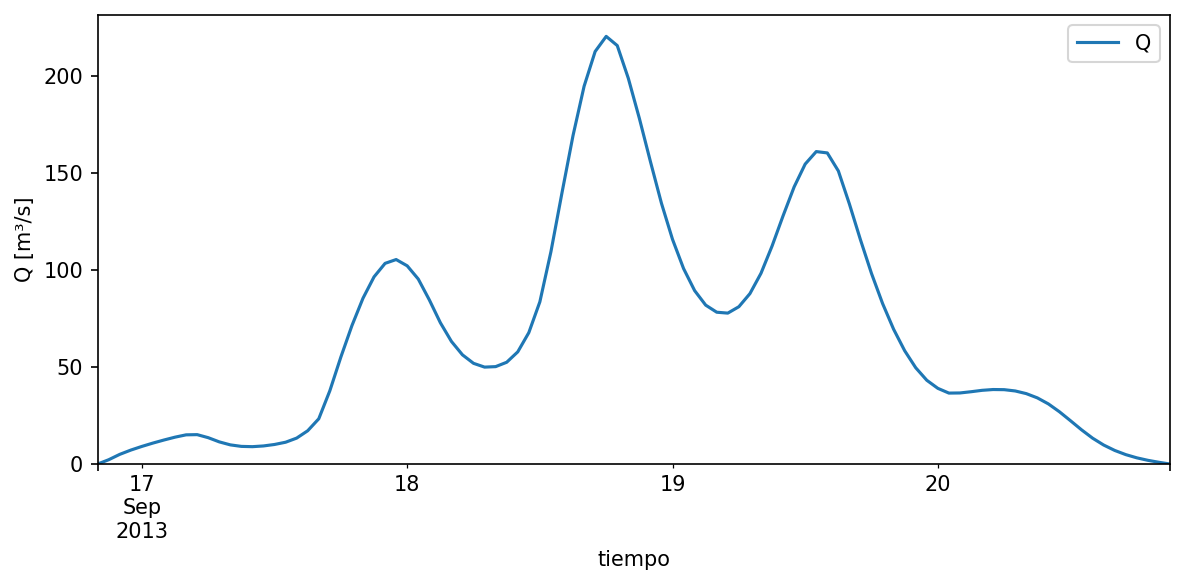

In [66]:
# Hidrograma para una tormeta múltiplo de d_e.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Graficamos.
calc_Q( esc, pre = [2, 5, 3] ).plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("Q [m³/s]")

fig.tight_layout()
plt.show()

In [67]:
# Hidrograma unitario instantáneo (matricial).

# Calculamos para un hidrograma y un hietograma.
def Hidro_mat( df, pre ):

    # Hacemos una copia del DataFrame.
    Q = df.copy()
    # Agregamos todas las fechas que están están
    # en el hietograma y no en el hidrograma.
    for i in pre.index[ ~pre.index.isin(Q.index) ]: Q.loc[ i ] = 0

    # Generamos la matriz P.
    P_i = []
    # La matriz P tiene M = K - N + 1 filas.
    for i in range(0, Q.shape[0] - pre.shape[0] + 1):
        P_i.append( pre.copy() )
        # Cada columna tiene la precipitación recorrida una vez.
        P_i[i].index = P_i[i].index.shift(i, freq = "H")

    # Los valores nulos, producto de recorrer la tabla, se llenan con 0.
    P = pd.concat(P_i, axis = 1).fillna(0)

    # Generamos el hidrograma unitario.
    U = np.linalg.inv( P.T @ P ) @ ( P.T @ Q )
    # Cambiamos el nombre de la columna.
    U = U.rename( {"Q_D": "q"}, axis = 1 )
    # Hacemos que el hidrograma empiece en 0.
    U.index += 1
    U.loc[0] = 0
    U = U.sort_index()
    # Nos aseguramos que no haya valores negativos.
    return U.where(U > 0, 0)

In [68]:
inf

,curva masa [mm],hp [mm],i [mm/h],he [mm],r [mm/h],f [mm/h]
tiempo,,,,,,
2013-09-15 15:00:00,0.000000,NaN,NaN,NaN,NaN,NaN
2013-09-15 16:00:00,0.163490,0.163490,0.163490,0.000000,0.022905,0.977095
2013-09-15 17:00:00,0.660499,0.497009,0.497009,0.000000,0.069631,0.930369
2013-09-15 18:00:00,1.310633,0.650134,0.650134,0.000000,0.091084,0.908916
2013-09-15 19:00:00,2.989180,1.678547,1.678547,0.382197,0.235166,0.764834
...,...,...,...,...,...,...
2013-09-18 00:00:00,91.225253,0.599587,0.599587,0.000000,0.084003,0.915997
2013-09-18 01:00:00,91.611467,0.386214,0.386214,0.000000,0.054109,0.945891
2013-09-18 02:00:00,91.856989,0.245522,0.245522,0.000000,0.034398,0.965602


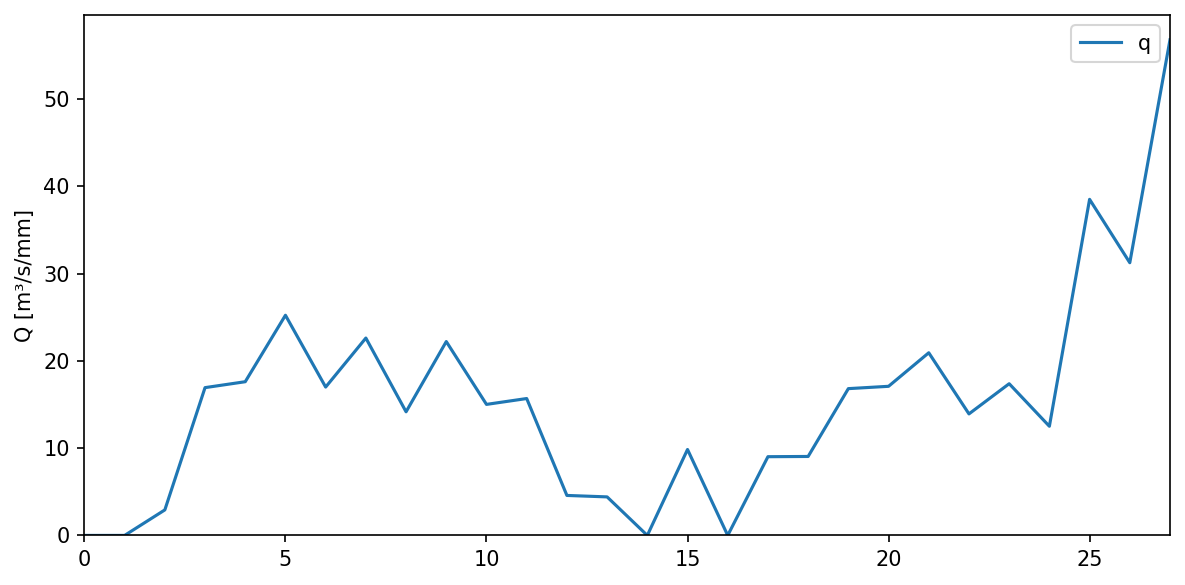

In [69]:
# Hidrograma unitario instantáneo (matricial).

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Hidrograma unitario.
Q_m = Hidro_mat( esc[ ["Q_D"] ],
    inf.loc[inf.index[1]:inf.index[-2], ["he [mm]"] ] )
# Volumen de escurrimiento unitario.
V_esc = integrate.simpson( Q_m["q"], Q_m.index * 3600 )
# Graficamos.
Q_m.plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_xlim( Q_m.index[0], Q_m.index[-1] )
ax.set_ylabel("Q [m³/s/mm]")

fig.tight_layout()
plt.show()

In [70]:
# Corregimos el hidrograma unitario para que tenga sentido físico.

# Eliminamos los valores que no tienen sentido físico.
Q_m.iloc[-1] = 0
Q_m.iloc[-2] = 0
Q_m.iloc[21:-2] = np.nan

# Interpolamos los valores faltantes.
Q_m = Q_m.interpolate("cubic")
# Ningún valor puede ser menor a cero.
Q_m = Q_m.where(Q_m > 0, 0)
# Volumen de escurrimiento unitario corregido.
V_corr = integrate.simpson( Q_m["q"], Q_m.index * 3600 )
# Ajustamos para mantener el volumen de escurrimiento.
Q_m = Q_m * V_esc / V_corr

Q_m

,q
0,0.000000
1,0.000000
2,4.233135
3,24.525268
4,25.507642
5,36.539922
6,24.620118
7,32.755051
8,20.514486
9,32.173708


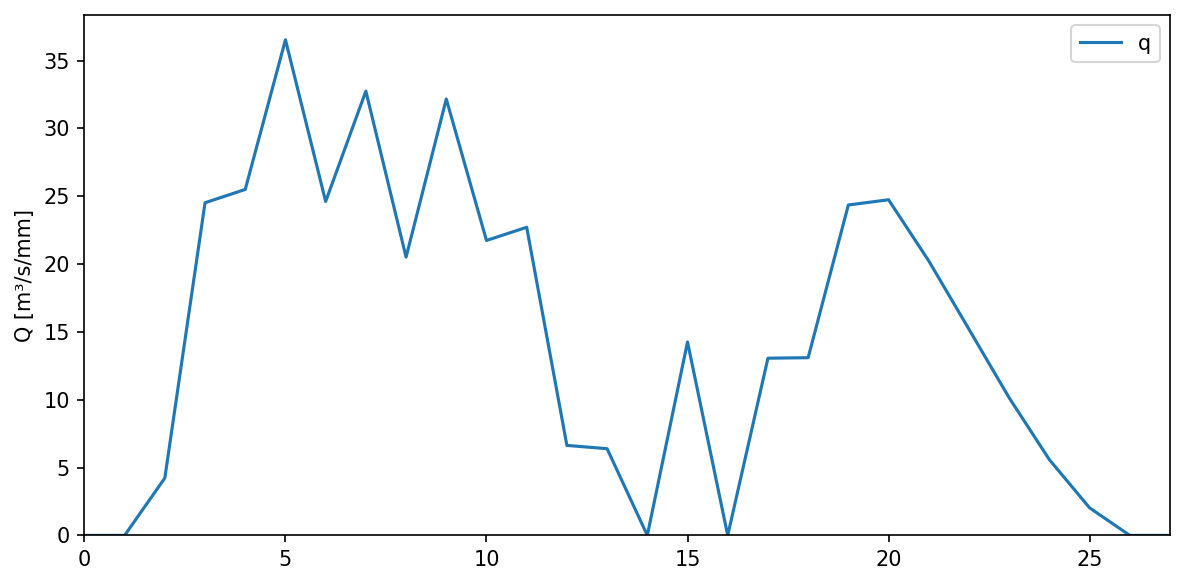

In [71]:
# Hidrograma unitario instantáneo (matricial).

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Graficamos.
Q_m.plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_xlim( Q_m.index[0], Q_m.index[-1] )
ax.set_ylabel("Q [m³/s/mm]")

fig.tight_layout()
plt.show()

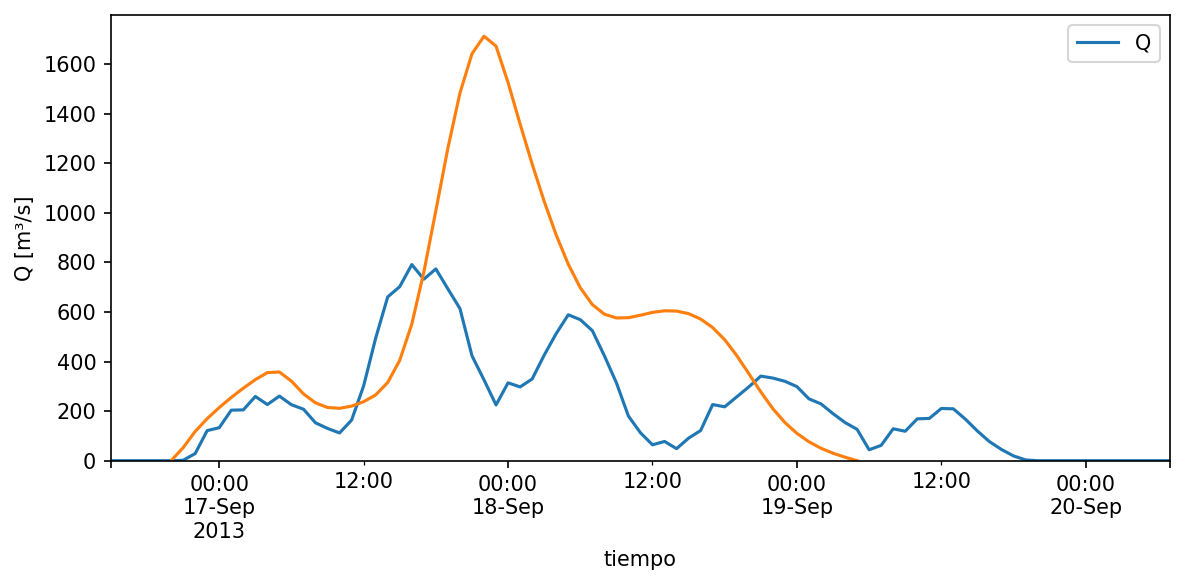

In [72]:
# Hidrograma de la tormenta a partir del método matricial.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(8, 4)
fig.set_dpi(150) 

# Hidrograma matricial.
Q = calc_Q( Q_m, pre = inf["he [mm]"] )
# Ajustamos el índice a una fecha.
Q.index = pd.date_range( "2013-09-16 15:00:00",
    periods = Q.shape[0], freq = "H" )

# Graficamos.
Q.plot(ax = ax)
esc["Q_D"].plot(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("Q [m³/s]")

fig.tight_layout()
plt.show()

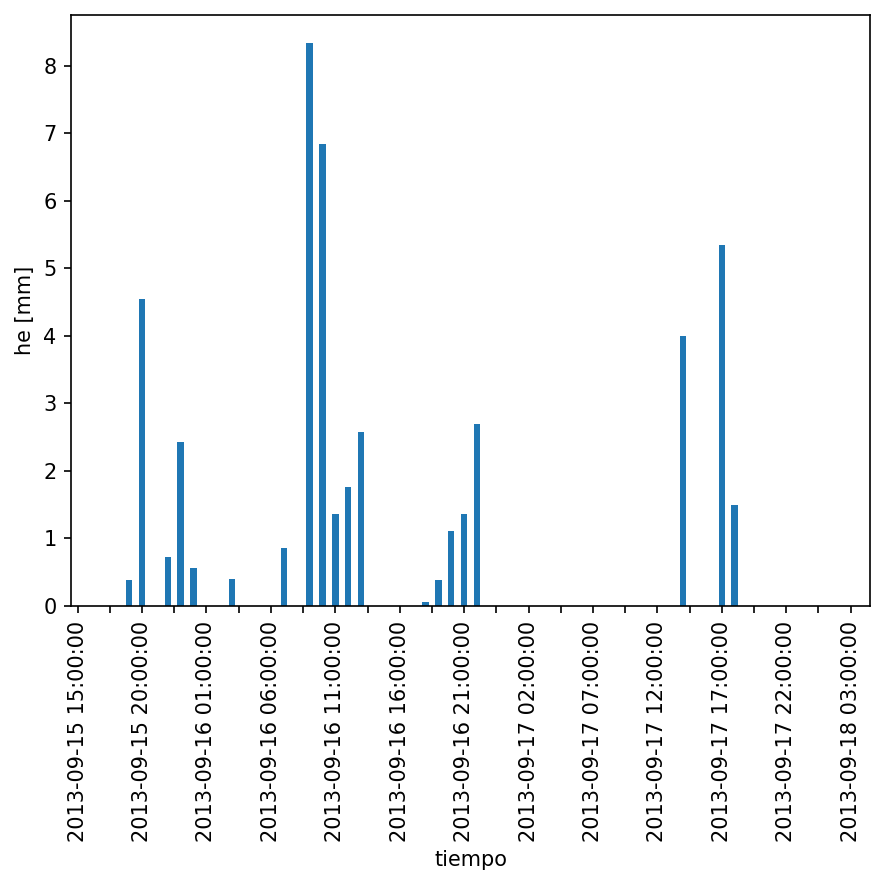

In [73]:
# Hietograma.

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos el hietograma.
inf["he [mm]"].plot.bar(ax = ax)

# Estilo.
ax.set_ylim(0)
ax.set_ylabel("he [mm]")
ax.xaxis.set_major_locator( plt.MaxNLocator(30) )

fig.tight_layout()
plt.show()